In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import pandas as pd
import numpy as np

In [26]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [27]:
df = pd.read_csv(r"/content/Consumer_Complaints.csv")
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


In [28]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [29]:
df = df[['Consumer complaint narrative','Product']]
df.head()
df.to_csv('complaint.csv',index=False)

In [30]:
df = pd.read_csv(r"/content/complaint.csv")
df.shape

(972147, 2)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972147 entries, 0 to 972146
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Consumer complaint narrative  249830 non-null  object
 1   Product                       972147 non-null  object
dtypes: object(2)
memory usage: 14.8+ MB


In [32]:
df['Product'].value_counts()

Mortgage                                                                        249039
Debt collection                                                                 185237
Credit reporting                                                                140433
Credit card                                                                      89191
Credit reporting, credit repair services, or other personal consumer reports     87625
Bank account or service                                                          86206
Student loan                                                                     41072
Consumer Loan                                                                    31607
Credit card or prepaid card                                                      18211
Checking or savings account                                                      15075
Payday loan                                                                       5546
Money transfers                            

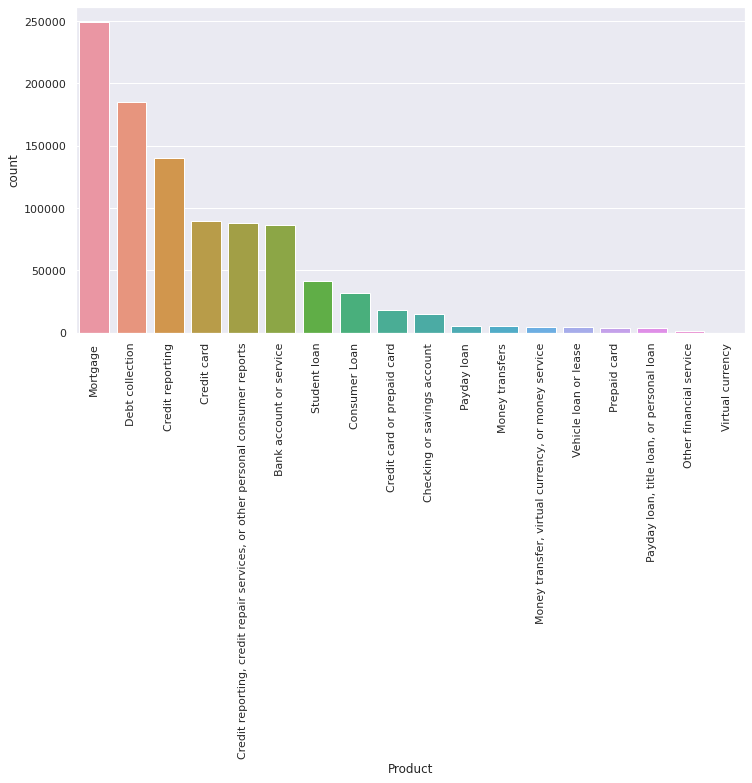

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.set(style='darkgrid')
sns.countplot(x='Product',data=df,order = df['Product'].value_counts().index)
plt.show()

In [34]:
df.Product.loc[(df['Product'] == "Credit reporting") | (df['Product'] == "Credit reporting, credit repair services, or other personal consumer reports") | 
         (df['Product'] == "Credit card") | (df['Product'] == "Credit card or prepaid card") | (df['Product'] == "Prepaid card")] = "Credit Card Related"

df.Product.loc[(df['Product'] == "Student loan") | (df['Product'] == "Consumer Loan") | 
         (df['Product'] == "Vehicle loan or lease") | (df['Product'] == "Payday loan") | (df['Product'] == "Payday loan, title loan, or personal loan")] = "Loan Related"

df.Product.loc[(df['Product'] == "Bank account or service") | (df['Product'] == "Checking or savings account") | 
         (df['Product'] == "Money transfer, virtual currency, or money service") | (df['Product'] == "Money transfers")] = "Bank Services"

df.Product.loc[(df['Product'] == "Debt collection") | (df['Product'] == "Mortgage") | 
         (df['Product'] == "Virtual currency") | (df['Product'] == "Other financial service") | (df['Product'] == "Prepaid card")] = "Others Services"

df.reset_index(inplace = True)
df.drop('index',axis='columns', inplace=True)

In [35]:
df.Product.value_counts()

Others Services        435354
Credit Card Related    339279
Bank Services          111307
Loan Related            86207
Name: Product, dtype: int64

In [36]:
df.isna().sum()

Consumer complaint narrative    722317
Product                              0
dtype: int64

In [37]:
df = df.dropna()

In [38]:
df = df.reset_index()
df.head(5)

,index,Consumer complaint narrative,Product
0,1,I have outdated information on my credit repor...,Credit Card Related
1,2,I purchased a new car on XXXX XXXX. The car de...,Loan Related
2,7,An account on my credit report has a mistaken ...,Credit Card Related
3,12,This company refuses to provide me verificatio...,Others Services
4,16,This complaint is in regards to Square Two Fin...,Others Services


In [39]:
def complain(index):
    example = df[df.index==index][['Consumer complaint narrative','Product']].values[0]
    if len(example)>0:
       print(example[0])
       print()
       print('Category : ',example[1])

In [40]:
complain(1)

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had been paid in full ( dated XXXX, XXXX ) but no refund check was included. XXXX stated that they hold any over payment for 10 business days after the loan was satisfied and that my check would be mailed ou

Finding out the total number of words in the DataFrame

In [41]:
print(df['Consumer complaint narrative'].apply(lambda x:len(x.split(' '))).sum())

49104243


In [42]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [43]:
def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ',text)
    text = extra_symbol_remover.sub('',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

In [44]:
print(df['Consumer complaint narrative'].apply(lambda x: len(x.split(' '))).sum())

24719687


In [45]:
complain(144)

ocwen charged xxxx postage sending notice default default payments made within grace period sent information prove responded

Category :  Others Services


In [46]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 128591 unique tokens.


In [47]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X,maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (249830, 250)


In [48]:
X

array([[   0,    0,    0, ...,    3,   38,  764],
       [   0,    0,    0, ...,  100,  669,  247],
       [   0,    0,    0, ...,  679,  586,   24],
       ...,
       [   0,    0,    0, ..., 2329, 1492,    8],
       [ 654,   16, 3922, ..., 2155,  107,  163],
       [   0,    0,    0, ...,  656, 2722, 1030]], dtype=int32)

In [49]:
y = pd.get_dummies(df['Product']).values
print("Shape of label tensor", y.shape)

Shape of label tensor (249830, 4)


In [50]:
y

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(224847, 250) (224847, 4)
(24983, 250) (24983, 4)


In [52]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
epochs = 5
batch_size=512

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
396/396 [==============================] - 672s 2s/step - loss: 0.5956 - accuracy: 0.7864 - val_loss: 0.4189 - val_accuracy: 0.8676
Epoch 2/5
396/396 [==============================] - 658s 2s/step - loss: 0.3889 - accuracy: 0.8724 - val_loss: 0.3855 - val_accuracy: 0.8755
Epoch 3/5
396/396 [==============================] - 671s 2s/step - loss: 0.3431 - accuracy: 0.8864 - val_loss: 0.3687 - val_accuracy: 0.8789
Epoch 4/5
396/396 [==============================] - 647s 2s/step - loss: 0.3172 - accuracy: 0.8946 - val_loss: 0.3602 - val_accuracy: 0.8794
Epoch 5/5
396/396 [==============================] - 654s 2s/step - loss: 0.2957 - accuracy: 0.9009 - val_loss: 0.3669 - val_accuracy: 0.8798


In [54]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [60]:
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1808  319   34  135]
 [ 154 8764  243  657]
 [  45  267 2501  281]
 [  68  668  362 8677]]


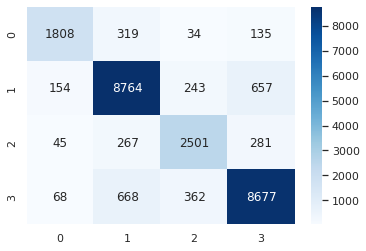

In [64]:
sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

In [ ]:
accuracy_score(y_test,y_pred)

In [65]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred)
print(labels[np.argmax(pred)])

[[0.03935719 0.9431169  0.00337984 0.01414607]]
Debt collection
